In [1]:
import os
import numpy as np 
import torch
import matplotlib.pyplot as plt
import cv2
from rembg import new_session, remove
from dataset import create_dataset, create_sampler, create_loader
import argparse
import ruamel.yaml as yaml
import json
os.chdir('/workspace')

/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def img_show(img):
    img = torch.permute(img,dims=(1,2,0)).detach().numpy()
    img = (img - np.min(img)) / (np.max(img) - np.min(img))
    plt.imshow(img)
    plt.axis(False)
    plt.show()
    
def img_show_2(img):
    img = (img - np.min(img)) / (np.max(img) - np.min(img))
    plt.imshow(img)
    plt.axis(False)
    plt.show()

def img_show_3(img):
    # Convert RGBA image to RGB by discarding the alpha channel
    img_rgb = cv2.cvtColor(img, cv2.COLOR_RGBA2RGB)

    # Normalize the image
    img_rgb = (img_rgb - np.min(img_rgb)) / (np.max(img_rgb) - np.min(img_rgb))

    # Display the image
    plt.imshow(img_rgb)
    plt.axis(False)
    plt.show()

### dataset load

In [3]:
parser = argparse.ArgumentParser()     
parser.add_argument('--config', default='./configs/Retrieval_coco_romix.yaml')
parser.add_argument('--output_dir', default='output/Retrieval_full_romix_wj')        
parser.add_argument('--checkpoint', default='')   
parser.add_argument('--text_encoder', default='bert-base-uncased')
parser.add_argument('--evaluate', action='store_true')
parser.add_argument('--device', default='cuda')
parser.add_argument('--seed', default=42, type=int)
parser.add_argument('--world_size', default=1, type=int, help='number of distributed processes')    
parser.add_argument('--dist_url', default='env://', help='url used to set up distributed training')
parser.add_argument('--distributed', default=True, type=bool)
args = parser.parse_args([])

config = yaml.load(open(args.config, 'r'), Loader=yaml.Loader)
config['output_dir'] = args.output_dir



In [4]:
config

{'train_file': ['data/COCO/Annotations/coco_train.json'],
 'val_file': 'data/COCO/Annotations/coco_val.json',
 'test_file': 'data/COCO/Annotations/coco_test.json',
 'image_root': 'data/COCO/Images',
 'obj_bg_threshold': 0.01,
 'bg_center_threshold': 0.7,
 'obj_bg_mix_ratio': 0.5,
 'img_info_json': 'data/COCO/Annotations/coco_img_info.json',
 'bert_config': 'configs/config_bert.json',
 'image_res': 384,
 'batch_size_train': 2,
 'batch_size_test': 2,
 'queue_size': 65536,
 'momentum': 0.995,
 'vision_width': 768,
 'embed_dim': 256,
 'temp': 0.07,
 'k_test': 256,
 'alpha': 0.4,
 'distill': True,
 'warm_up': True,
 'optimizer': {'opt': 'adamW', 'lr': 1e-05, 'weight_decay': 0.02},
 'schedular': {'sched': 'cosine',
  'lr': 1e-05,
  'epochs': 5,
  'min_lr': 1e-06,
  'decay_rate': 1,
  'warmup_lr': 1e-05,
  'warmup_epochs': 1,
  'cooldown_epochs': 0},
 'romixgen': True,
 'romixgen_ratio': 1,
 'romixgen_resize_ratio': 2,
 'romixgen_img_mix': True,
 'mixgen': True,
 'mixgen_ratio': 1,
 'mixgen_r

In [5]:
train_dataset, val_dataset, test_dataset = create_dataset('re', config)  

/usr/local/lib/python3.8/dist-packages/torchvision/transforms/transforms.py:891: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/transforms/transforms.py:332: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  warnings.warn(


In [7]:
temp_obj_id , temp_bg_id = train_dataset.romixgen.obj_bg_dict["obj"][12344], train_dataset.romixgen.obj_bg_dict["bg"][390]
print("obj_id: ", temp_obj_id, "bg_id: ", temp_bg_id)

obj_id:  572301 bg_id:  569747


In [8]:
temp_obj_filename = train_dataset.romixgen.image_info_dict[temp_obj_id]["file_name"]
temp_bg_filename = train_dataset.romixgen.image_info_dict[temp_bg_id]["file_name"]

temp_obj_img = cv2.imread(os.path.join(train_dataset.romixgen.img_aug.image_root,temp_obj_filename), cv2.IMREAD_COLOR)
temp_obj_img = cv2.cvtColor(temp_obj_img, cv2.COLOR_BGR2RGB)
temp_bg_img = cv2.imread(os.path.join(train_dataset.romixgen.img_aug.image_root,temp_bg_filename), cv2.IMREAD_COLOR)
temp_bg_img = cv2.cvtColor(temp_bg_img, cv2.COLOR_BGR2RGB)

In [90]:
temp_obj_caption = train_dataset.romixgen.image_info_dict[temp_obj_id]["captions"][np.random.randint(0,5)]
temp_bg_caption = train_dataset.romixgen.image_info_dict[temp_bg_id]["captions"][np.random.randint(0,5)]
temp_bg_caption_split = [temp_bg_caption.split(" ")[i:i+3] for i in range(0, len(temp_bg_caption.split(" ")), 3)] 
temp_obj_caption_split = [temp_obj_caption.split(" ")[i:i+3] for i in range(0, len(temp_obj_caption.split(" ")), 3)]
temp_result = [a+b for a, b in zip(temp_obj_caption_split, temp_bg_caption_split)] + temp_obj_caption_split[len(temp_bg_caption_split):] + temp_bg_caption_split[len(temp_obj_caption_split):]
# add all item in the list
temp_result = [item for sublist in temp_result for item in sublist]
temp_result = " ".join(temp_result)
temp_result

In [91]:
temp_result = [a+b for a, b in zip(temp_obj_caption_split, temp_bg_caption_split)] + temp_obj_caption_split[len(temp_bg_caption_split):] + temp_bg_caption_split[len(temp_obj_caption_split):]

In [92]:
# add all item in the list
temp_result = [item for sublist in temp_result for item in sublist]

In [114]:
temp_obj_caption = train_dataset.romixgen.image_info_dict[temp_obj_id]["captions"][np.random.randint(0,5)]
temp_bg_caption = train_dataset.romixgen.image_info_dict[temp_bg_id]["captions"][np.random.randint(0,5)]
temp_obj_caption_split = [temp_obj_caption.split(" ")[i:i+3] for i in range(0, len(temp_obj_caption.split(" ")), 3)]
temp_bg_caption_split = [temp_bg_caption.split(" ")[i:i+3] for i in range(0, len(temp_bg_caption.split(" ")), 3)]
temp_result = [x for pair in zip(temp_obj_caption_split, temp_bg_caption_split) for x in pair] + temp_obj_caption_split[len(temp_bg_caption_split):] + temp_bg_caption_split[len(temp_obj_caption_split):]
temp_result = " ".join(item for sublist in temp_result for item in sublist)
temp_result

'A glass bowl A group of filled with lemons people walk down behind a plate the street. of fruit.'

In [112]:
temp_obj_caption = np.random.choice(train_dataset.romixgen.image_info_dict[temp_obj_id]["captions"])
temp_bg_caption = np.random.choice(train_dataset.romixgen.image_info_dict[temp_bg_id]["captions"])
print(temp_obj_caption)
print(temp_bg_caption)
temp_obj_caption_split = [temp_obj_caption.split(" ")[i:i+3] for i in range(0, len(temp_obj_caption.split(" ")), 3)]
temp_bg_caption_split = [temp_bg_caption.split(" ")[i:i+3] for i in range(0, len(temp_bg_caption.split(" ")), 3)]
print(temp_obj_caption_split)
print(temp_bg_caption_split)

A glass bowl filled with lemons behind a plate of fruit.
An Ally full of buildings in a town
[['A', 'glass', 'bowl'], ['filled', 'with', 'lemons'], ['behind', 'a', 'plate'], ['of', 'fruit.']]
[['An', 'Ally', 'full'], ['of', 'buildings', 'in'], ['a', 'town']]


In [113]:

temp_result = [x for pair in zip(temp_obj_caption_split, temp_bg_caption_split) for x in pair]
temp_result += [item for sublist in temp_obj_caption_split[len(temp_bg_caption_split):] + temp_bg_caption_split[len(temp_obj_caption_split):] for item in sublist]
temp_result = [item for sublist in temp_result for item in sublist]  # flatten the list of lists
temp_result = " ".join(temp_result)
print(temp_result)

A glass bowl An Ally full filled with lemons of buildings in behind a plate a town o f f r u i t .


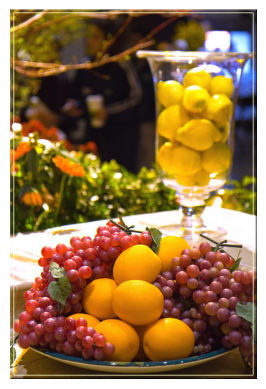

['A glass bowl filled with lemons behind a plate of fruit.', 'A plate with grapes and oranges and a vase of oranges.', 'A plate of grapes and oranges on a table.', 'A plate of fruit sits in front of a vase full of lemons.', 'Some lemons are in a vase and oranges and grapes are in a plate.']


In [6]:
img_show_2(temp_obj_img)
print(train_dataset.romixgen.image_info_dict[temp_obj_id]["captions"])

In [7]:
model_name = "isnet-general-use"
#model_name = "u2net"
session = new_session(model_name)

2023-05-24 02:14:56.028299488 [W:onnxruntime:Default, onnxruntime_pybind_state.cc:515 CreateExecutionProviderInstance] Failed to create TensorrtExecutionProvider. Please reference https://onnxruntime.ai/docs/execution-providers/TensorRT-ExecutionProvider.html#requirements to ensure all dependencies are met.


In [8]:
result = remove(temp_obj_img,
                session=session,
                post_process_mask=True,
                alpha_matting=False,
                only_mask=True
                )

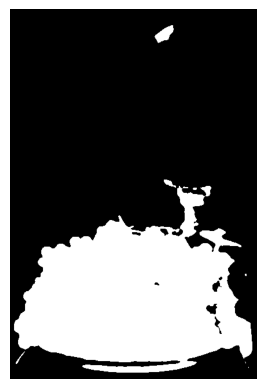

In [9]:
img_show_3(result)

In [10]:
type(result)

numpy.ndarray

In [11]:
import numpy as np
from pycocotools import mask as maskUtils

def get_segmentation_list(mask):
     # Find the indices where the mask is 255
    indices = np.argwhere(mask == 255)
    # Compute the run-length encoding of the mask
    rle = []
    prev = -2
    for index in indices:
        if index[0] == prev + 1:
            rle[-1][1] += 1
        else:
            rle.append([index[0], index[1], 1])
        prev = index[0]

    # Convert the run-length encoding to the format you specified
    segmentation = []
    for r in rle:
        segmentation += [float(r[1]), float(r[0] + 1), float(r[1] + r[2]), float(r[0] + 1), float(r[1] + r[2]), float(r[0] + 2)]

    # Return the segmentation list
    return [segmentation]

In [12]:
polygons = get_segmentation_list(result)

In [13]:
polygons

[[278.0,
  29.0,
  279.0,
  29.0,
  279.0,
  30.0,
  279.0,
  29.0,
  280.0,
  29.0,
  280.0,
  30.0,
  280.0,
  29.0,
  281.0,
  29.0,
  281.0,
  30.0,
  282.0,
  29.0,
  283.0,
  29.0,
  283.0,
  30.0,
  277.0,
  30.0,
  278.0,
  30.0,
  278.0,
  31.0,
  278.0,
  30.0,
  279.0,
  30.0,
  279.0,
  31.0,
  279.0,
  30.0,
  280.0,
  30.0,
  280.0,
  31.0,
  280.0,
  30.0,
  281.0,
  30.0,
  281.0,
  31.0,
  282.0,
  30.0,
  283.0,
  30.0,
  283.0,
  31.0,
  274.0,
  31.0,
  275.0,
  31.0,
  275.0,
  32.0,
  275.0,
  31.0,
  276.0,
  31.0,
  276.0,
  32.0,
  276.0,
  31.0,
  277.0,
  31.0,
  277.0,
  32.0,
  277.0,
  31.0,
  278.0,
  31.0,
  278.0,
  32.0,
  278.0,
  31.0,
  279.0,
  31.0,
  279.0,
  32.0,
  279.0,
  31.0,
  280.0,
  31.0,
  280.0,
  32.0,
  280.0,
  31.0,
  281.0,
  31.0,
  281.0,
  32.0,
  282.0,
  31.0,
  283.0,
  31.0,
  283.0,
  32.0,
  272.0,
  32.0,
  273.0,
  32.0,
  273.0,
  33.0,
  273.0,
  32.0,
  274.0,
  32.0,
  274.0,
  33.0,
  274.0,
  32.0,
  275.0,
  32.